In [ ]:
# as a note, this was my first attempt and this model was bad

import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labeled_solo_path = '/content/drive/My Drive/GA/Capstone/capstone/images/CelticsImages/Labeled/Solo'


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80-20 split between train and validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=labeled_solo_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

Found 512 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    directory=labeled_solo_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 128 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # dropout to reduce overfitting (but not too high because I don't have that much data to work with)
x = Dense(1, activation='sigmoid')(x)  # Binary classification (Celtic or not)

In [ ]:
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,  # Train for up to 100 epochs
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 825ms/step - accuracy: 0.5696 - loss: 0.6773 - val_accuracy: 0.7422 - val_loss: 0.4915
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 406ms/step - accuracy: 0.7803 - loss: 0.4579 - val_accuracy: 0.7422 - val_loss: 0.4886
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 504ms/step - accuracy: 0.7965 - loss: 0.4538 - val_accuracy: 0.7734 - val_loss: 0.4321
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.8257 - loss: 0.3611 - val_accuracy: 0.8281 - val_loss: 0.3848
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 449ms/step - accuracy: 0.8492 - loss: 0.3289 - val_accuracy: 0.8594 - val_loss: 0.3578
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 451ms/step - accuracy: 0.8538 - loss: 0.3237 - val_accuracy: 0.8438 - val_loss: 0.3614
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 651ms/step - accuracy: 0.9079 - loss: 0.2665 - val_accuracy: 0.8359 - val_loss: 0.3333
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 404ms/step - accuracy: 0.8706 - loss: 0.2830 - val_accuracy

In [ ]:
best_epoch = np.argmin(history.history['val_loss'])  # Epoch with the minimum validation loss
best_val_loss = history.history['val_loss'][best_epoch]

In [1]:
best_epoch

NameError: name 'best_epoch' is not defined

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
test_acc= history.history['val_accuracy']

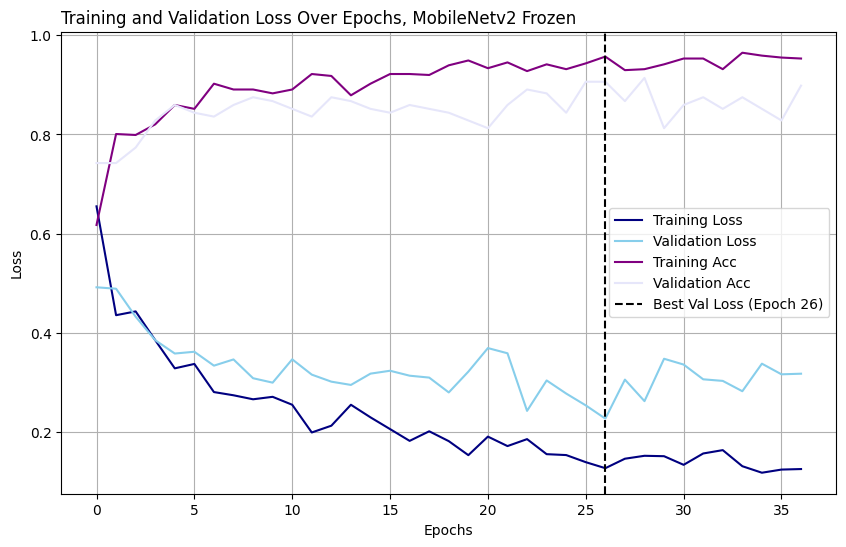

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, color='navy', label='Training Loss')
plt.plot(val_loss, color='skyblue', label='Validation Loss')
plt.plot(train_acc, color='Purple', label='Training Acc')
plt.plot(test_acc, color='lavender', label='Validation Acc')
plt.axvline(x=best_epoch, color='black', linestyle='--', label=f'Best Val Loss (Epoch {best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs, MobileNetv2 Frozen', loc='left')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_dir = '/content/drive/My Drive/GA/Capstone/capstone/models'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
model_path = os.path.join(model_dir, 'celtics_classifier1.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/GA/Capstone/capstone/models/celtics_classifier1.h5


In [ ]:
# Fine-tuning the top layers of the model while leaving the base layers intact,
# in the hopes that this will improve performance without causing overfitting issues

In [ ]:
base_model.trainable = True

In [ ]:
early_stopping_fine_tune = EarlyStopping(
    monitor='val_loss',
    patience=25,  # increasing patience to 25 to accomodate for decreased learning rate
    restore_best_weights=True
)

In [ ]:
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001),  # lower learning rate to reduce overfitting
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_fine_tune = model.fit(
    train_generator,
    epochs=100,  # Adjust as needed
    validation_data=val_generator,
    callbacks=[early_stopping_fine_tune]
)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 664ms/step - accuracy: 0.8402 - loss: 0.4162 - val_accuracy: 0.8438 - val_loss: 0.3630
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.8530 - loss: 0.3218 - val_accuracy: 0.8438 - val_loss: 0.4242
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 493ms/step - accuracy: 0.8552 - loss: 0.3380 - val_accuracy: 0.7734 - val_loss: 0.6022
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - accuracy: 0.8909 - loss: 0.2575 - val_accuracy: 0.7656 - val_loss: 0.7210
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 417ms/step - accuracy: 0.9155 - loss: 0.2130 - val_accuracy: 0.7109 - val_loss: 0.6696
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 516ms/step - accuracy: 0.9141 - loss: 0.1864 - val_accuracy: 0.7188 - val_loss: 0.7402
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.9128 - loss: 0.2095 - val_accuracy: 0.8047 - val_loss: 0.6292
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 473ms/step - accuracy: 0.9496 - loss: 0.1807 - 

In [ ]:
best_epoch_fine = np.argmin(history_fine_tune.history['val_loss'])  # epochT with the minimum validation loss
best_val_loss_fine = history_fine_tune.history['val_loss'][best_epoch]

In [ ]:
train_loss_fine = history_fine_tune.history['loss']
val_loss_fine = history_fine_tune.history['val_loss']
train_acc_fine = history_fine_tune.history['accuracy']
test_acc_fine = history_fine_tune.history['val_accuracy']

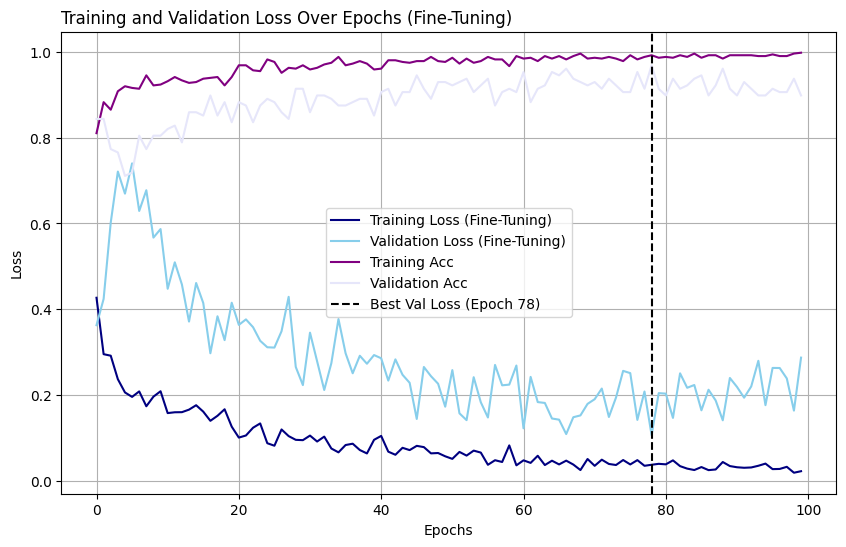

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_fine, color='navy', label='Training Loss (Fine-Tuning)')
plt.plot(val_loss_fine, color='skyblue', label='Validation Loss (Fine-Tuning)')
plt.plot(train_acc_fine, color='Purple', label='Training Acc')
plt.plot(test_acc_fine, color='lavender', label='Validation Acc')
plt.axvline(x=best_epoch_fine, color='black', linestyle='--', label=f'Best Val Loss (Epoch {best_epoch_fine})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Fine-Tuning)', loc='left')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_path = os.path.join(model_dir, 'celtics_classifier_fine_tuned2.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/GA/Capstone/capstone/models/celtics_classifier_fine_tuned2.h5
